In [36]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

import torch.optim as optim
from torchvision import transforms, models
import numpy as np
from PIL import Image

In [37]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
    param.requires_grad = (False)

In [38]:
device = torch.device("cuda:0")

In [39]:
vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [40]:
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = in_transform(image).unsqueeze(0)
    return image

In [41]:
city = load_image('./data/Images/City.jpg').to(device)
content = city
mona = load_image('./data/Images/MonaLisa.jpg').to(device)
star = load_image('./data/Images/StarryNight.jpg', shape=content.shape[-2:]).to(device)
style = star

In [42]:
def image_convert(tensor):
    image = tensor.cpu().clone().detach().numpy()
    image = image.squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0,1)
    return image

(-0.5, 599.5, 399.5, -0.5)

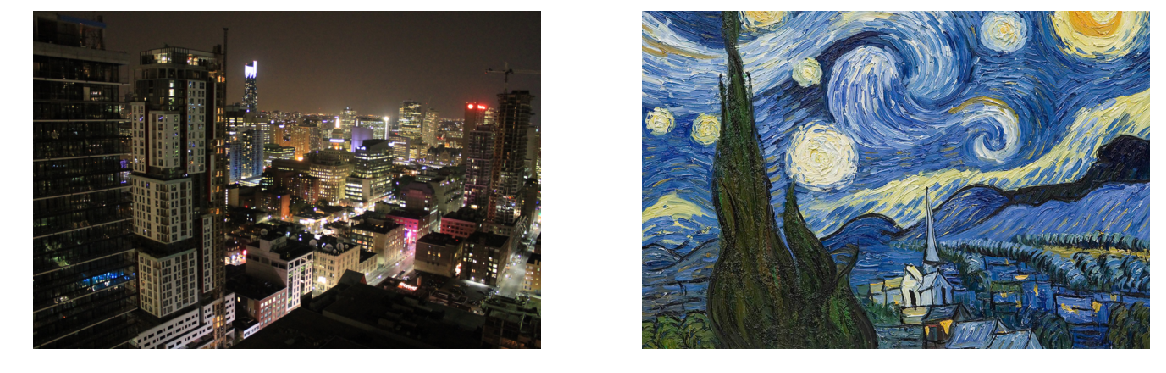

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.imshow(image_convert(content))
ax1.axis('off')

ax2.imshow(image_convert(style))
ax2.axis('off')

In [44]:
def get_features(image, model):
    
    layers = {
        '0': 'conv1_1',
        '5': 'conv2_1',
        '10': 'conv3_1',
        '19': 'conv4_1',
        '21': 'conv4_2', # we will use this one for content extraction
        '28': 'conv5_1'
    }
    
    features = {}
    
    for name, layer in model._modules.items():
        image = layer(image)    
        if name in layers:
            features[layers[name]] = image
            
    return features

In [45]:
content_features = get_features(image=content, model=vgg)
style_features = get_features(image=style, model=vgg)

In [46]:
def gram_matrix(tensor):
    batch, depth, height, width = tensor.size()
    
    tensor = tensor.view(depth, height*width) # reshaped into a 2D tensor
    gram = torch.mm(tensor, tensor.t())
    return gram

In [47]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

In [48]:
style_weights = {
    'conv1_1': 1.0,
    'conv2_1': 0.75,
    'conv3_1': 0.2,
    'conv4_1': 0.2,
    'conv5_1': 0.2
}

content_weight = 1
style_weight = 10^6

In [49]:
target = content.clone().requires_grad_(True).to(device)

In [50]:
show_every = 300
optimizer = optim.Adam([target], lr=0.003)
steps = 300 * 34

In [51]:
height, width, channels = image_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))
capture_frame = steps / 300

counter = 0

Iteration: 300
Total Loss: 39.483699798583984


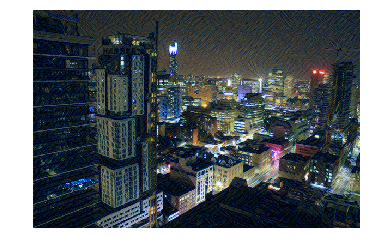

Iteration: 600
Total Loss: 16.059764862060547


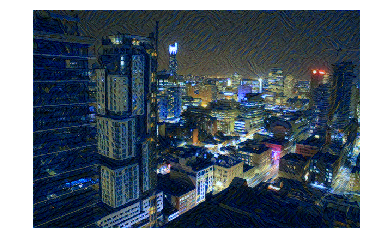

Iteration: 900
Total Loss: 12.336463928222656


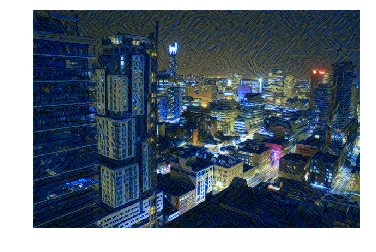

Iteration: 1200
Total Loss: 10.389463424682617


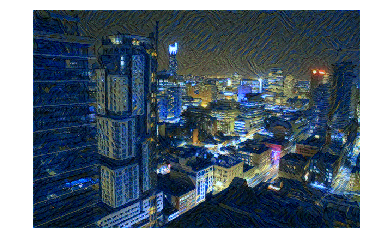

Iteration: 1500
Total Loss: 8.948830604553223


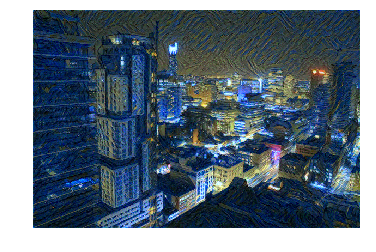

Iteration: 1800
Total Loss: 7.821143627166748


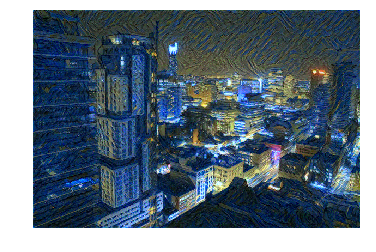

Iteration: 2100
Total Loss: 6.921389579772949


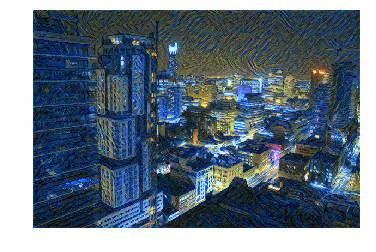

Iteration: 2400
Total Loss: 6.1947832107543945


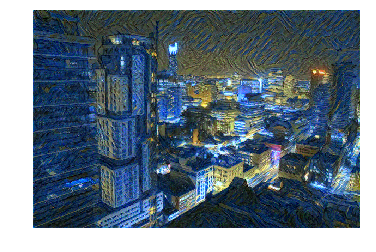

Iteration: 2700
Total Loss: 5.609695911407471


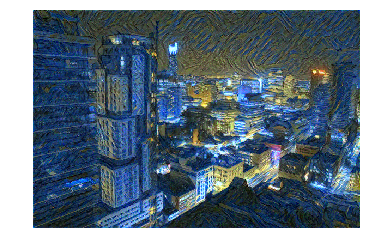

Iteration: 3000
Total Loss: 5.140936851501465


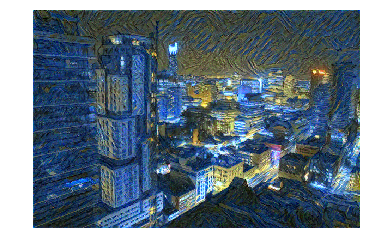

Iteration: 3300
Total Loss: 4.767767429351807


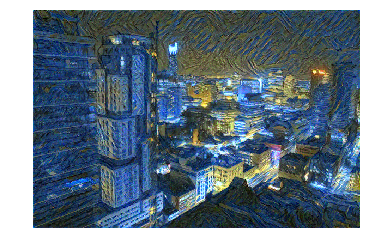

Iteration: 3600
Total Loss: 4.474423885345459


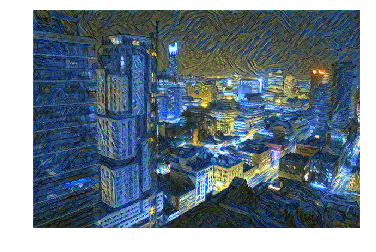

Iteration: 3900
Total Loss: 4.24563455581665


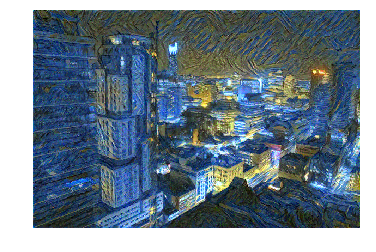

Iteration: 4200
Total Loss: 4.068089008331299


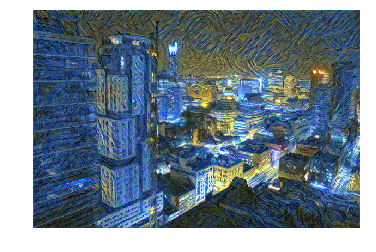

Iteration: 4500
Total Loss: 3.931425094604492


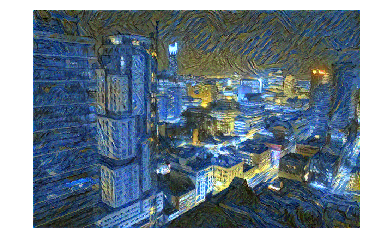

Iteration: 4800
Total Loss: 3.8275322914123535


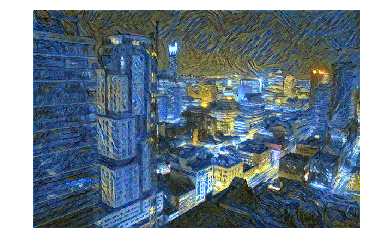

Iteration: 5100
Total Loss: 3.745698928833008


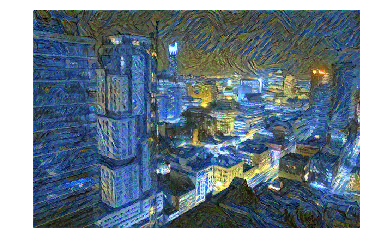

Iteration: 5400
Total Loss: 3.6818618774414062


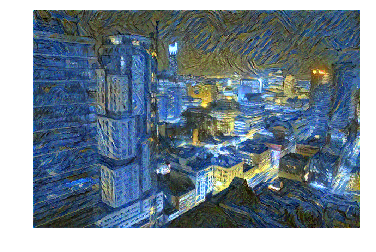

Iteration: 5700
Total Loss: 3.629051923751831


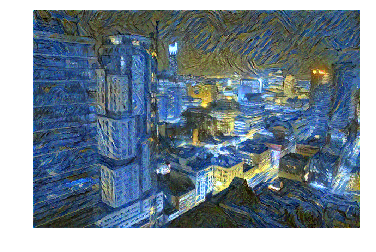

Iteration: 6000
Total Loss: 3.583662509918213


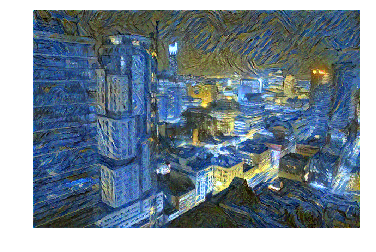

Iteration: 6300
Total Loss: 3.547150135040283


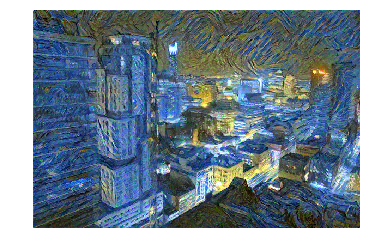

In [ ]:
for ii in range(1, steps+1):
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, depth, height, width = target_feature.shape
        
        style_loss += layer_style_loss / (depth * height * width)
        
    total_loss = content_loss*content_weight + style_loss*style_weight
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    if ii % show_every == 0:
        print(f'Iteration: {ii}')
        print(f'Total Loss: {total_loss.item()}')
        plt.imshow(image_convert(target))
        plt.axis('off')
        plt.show()
        
    if ii % capture_frame == 0:
        image_array[counter] = image_convert(target)
        counter += 1
        

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,20))

ax1.imshow(image_convert(content))
ax1.axis('off')

ax2.imshow(image_convert(style))
ax2.axis('off')

ax3.imshow(image_convert(target))
ax3.axis('off')

In [ ]:
import cv2
frame_height, frame_width, _ = image_convert(target).shape
vid = cv2.VideoWriter('final_output.mp4', cv2.VideoWriter_fourcc(*'XVID'), 30, (frame_width, frame_height))

In [ ]:
for i in range(len(image_array)):
    img = image_array[i]
    img = img * 255
    img = np.array(img, dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    vid.write(img)
vid.release()

In [ ]:
for i in content_features:
    print(i)
    plt.imshow(image_convert(content_features[i]))